Initial import and reading files

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import pandas as pd
import geopandas as gpd
from highlight_text import fig_text

greenhouse_file = 'greenhouse-emissions.csv'
renewable_energy_share_file = 'renewable-share-energy.csv'

# Reading the files
greenhouse_emissions_data = pd.read_csv(greenhouse_file)
renewable_energy_share_data = pd.read_csv(renewable_energy_share_file)

Function to visualize the data on the map of Europe

In [6]:
def show_map(column_name, min_rate, max_rate, df, number_addition, colours, title, legend_name):
    # Displaying the map
    world = gpd.read_file("./map/ne_110m_admin_0_countries.shp")
    europe = world[world['CONTINENT'] == 'Europe']

    data = europe.merge(df, how='left', left_on='NAME', right_on='Country')

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # define colors
    cmap = colours
    min_rate, max_rate = min_rate, max_rate
    norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)

    # create the plot
    data.plot(column=column_name, cmap=cmap, norm=norm, ax=ax)

    # custom axis
    ax.set_xlim(-15, 35)
    ax.set_ylim(32, 72)
    ax.axis('off')

    # add a title
    fig.text(0.02, 0.88, title,
         fontsize=16, fontweight='bold', fontfamily='serif')

    # Add color legend
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label(f"{legend_name} ({number_addition})", fontsize=10)

    data_projected = data.to_crs(epsg=3035)
    data_projected['centroid'] = data_projected.geometry.centroid
    data['centroid'] = data_projected['centroid'].to_crs(data.crs)
    
    adjustments = {
        'France': (9, 3),
        'Italy': (-2.4, 2),
        'Lithuania': (0, -0.6),
        'Finland': (0, -2.5),
        'Romania': (0, -0.5),
        'Bulgaria': (0, -0.6),
        'Greece': (-1.2, -0.8),
        'Croatia': (0, -1),
        'Cyprus': (0, -1),
        'Ireland': (0, -1),
        'Malta': (0, -1),
        'Slovenia': (0, -1),
        'Slovakia': (-0.7, -0.8),
        'Estonia': (0, -0.7),
        'Latvia': (0, -0.5),
        'Belgium': (0, -0.7),
        'Austria': (0, -1),
        'Spain': (0, -1),
        'Portugal': (-0.5, -1),
        'Luxembourg': (0, -1),
        'Germany': (-0.2, 0),
        'Hungary': (-0.3, -1),
        'Czechia': (0, -1),
        'Poland': (0, -1),
        'Sweden': (-1.5, -1),
        'Denmark': (0, -1),
        'Netherlands': (0, 0),
        'United Kingdom': (0, -1),
        'Switzerland': (0, -0.5),
    }


    for country in data['Country']:
        if country != country:
            continue
        # get centroid
        centroid = data.loc[data['NAME'] == country, 'centroid'].values[0]
        x, y = centroid.coords[0]

        if country in adjustments:
            # get corrections
            x += adjustments[country][0]
            y += adjustments[country][1]

        # get rate and annotate
        rate = round(data.loc[data['NAME'] == country, column_name].values[0], 2)
        ax.annotate(f'{country} {rate}{number_addition}', (x, y), textcoords="offset points", xytext=(5, 5),
                    ha='center', fontsize=5, fontweight='bold', fontfamily='DejaVu Sans', color='black')

    # display the plot
    plt.tight_layout()
    plt.show()

Here are the helper functions that use `merged_data` and given year (ex. `2020`) to filter the data on the given year and show the map.

In [7]:
def show_renewable_energy_for_year(year, renewable_energy_share_data):
    # Filtering the data on the year to display on the map
    renewable_energy_amount = renewable_energy_share_data[renewable_energy_share_data['Year'] == year]['Renewables (% equivalent primary energy)']
    renewable_energy_countries = renewable_energy_share_data[renewable_energy_share_data['Year'] == year]['geo']

    re_df = pd.DataFrame({'Country': renewable_energy_countries, 'Renewables': renewable_energy_amount})
    show_map('Renewables', 0, 100, re_df, '%', cm.Greens, 'Renewable Energy Share in ' + str(year), "Renewable Energy Share")

def show_greenhouse_emissions_for_year(year, greenhouse_emissions_data):
    # Filtering the data on the year to display on the map
    greenhouse_emissions_amount = greenhouse_emissions_data[greenhouse_emissions_data['TIME_PERIOD'] == year]['OBS_VALUE']
    greenhouse_emissions_countries = greenhouse_emissions_data[greenhouse_emissions_data['TIME_PERIOD'] == year]['geo']

    max_emissions = greenhouse_emissions_amount.max()
    min_emissions = greenhouse_emissions_amount.min()

    ge_df = pd.DataFrame({'Country': greenhouse_emissions_countries, 'OBS_VALUE': greenhouse_emissions_amount})

    show_map('OBS_VALUE', min_emissions, max_emissions, ge_df, ' tons', cm.Reds, f'Greenhouse Emissions in {year}', "Emissions")

This is the year that visualization uses to show the data on the map

In [8]:
year = 2020

Merging both data frames for easier access and filtering the countries. Some countries are not present in both data sets.

In [9]:
# Merging both data frames for easier access and filtering the countries. Some countries are not present in both data sets.
merged_data = pd.merge(greenhouse_emissions_data, renewable_energy_share_data, how='outer', left_on=['geo', 'TIME_PERIOD'], right_on=['Entity', 'Year'])

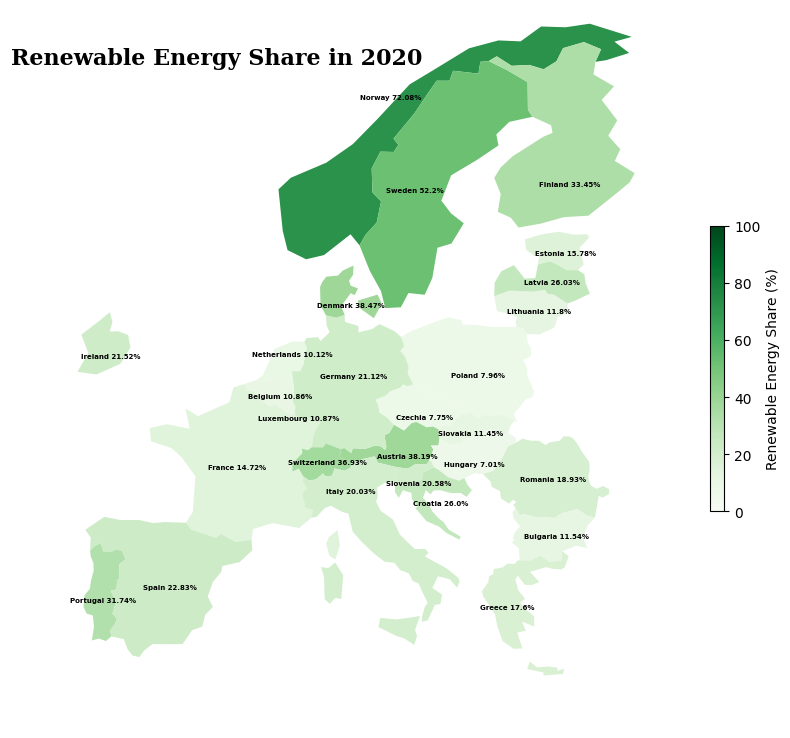

In [10]:
show_renewable_energy_for_year(year, merged_data)

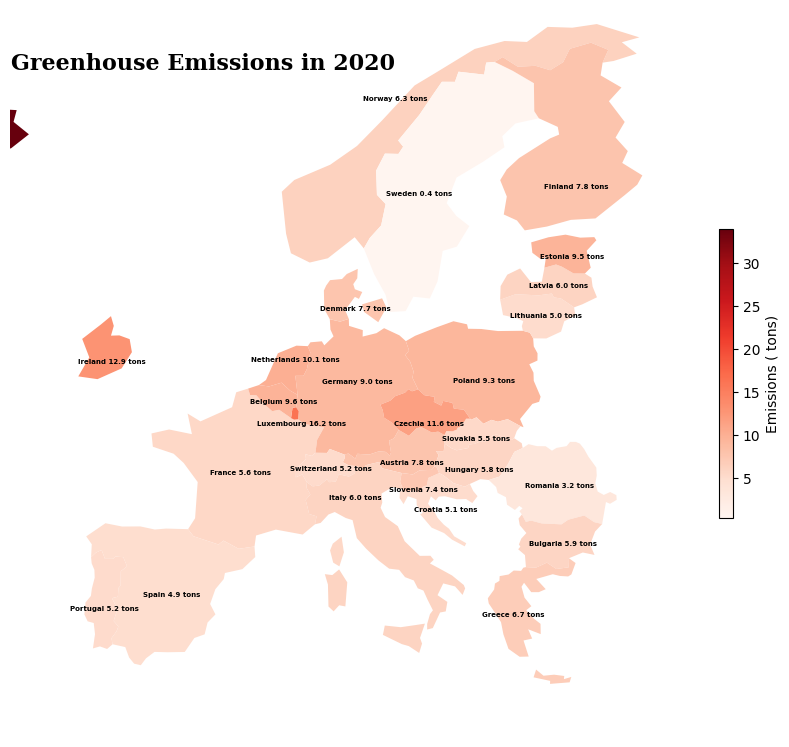

In [11]:
show_greenhouse_emissions_for_year(year, merged_data)